# Planning Evaluator

> Evaluator for planning performance using the Cross-Entropy Method (CEM) for optimization of discrete action sequences.

In [ ]:
# | default_exp evaluators.planning_eval

In [ ]:
#| hide
from nbdev.showdoc import *  

In [ ]:
#| export 
from fastcore.utils import *
import pandas as pd
import wandb
import os
from mawm.data.utils import base_tf, msg_tf
import numpy as np
import torch
import torch.nn.functional as F
from einops import repeat

/home/ahmed/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| export
def preprocessor(env, obs, info= False, pos=True, get_msg=True):
    obs_transformed = {}
    positions = {}
    goals = {}
    messages = {}
    goal_pos = obs["global"]["goal_pos"]

    agents = [f'agent_{i}' for i in range(env.num_agents)]
    for i, agent_id in enumerate(agents):
        obs_transformed[agent_id] = base_tf(obs[agent_id]['pov'].astype(np.uint8))  # Add batch dimension
        goal = env.get_goal(env.agents[i], goal_pos)[0]
        goals[agent_id] = base_tf(goal.astype(np.uint8))

        if pos:
            positions[agent_id] = torch.from_numpy(obs[agent_id]['selfpos'])
        if get_msg:
            done = info[agent_id]["done"] if info else info
            m = msg_tf((obs[agent_id]['pov'], agent_id, done, True))
            messages[agent_id] = m


    if pos and get_msg:
        return obs_transformed, positions, goals, messages
    elif pos:
        return obs_transformed, positions, goals
    elif get_msg:
        return obs_transformed, messages
    else:
        return obs_transformed

### Debugging

In [ ]:
#| hide
from mawm.envs.marl_grid import make_env
from mawm.envs.marl_grid.cfg import config
import copy
import numpy as np
from mawm.envs.marl_grid.wrappers import GridRecorder

seed = 1#np.random.randint(0, 10000)
cfg = copy.deepcopy(config)
cfg.env_cfg.seed = int(seed)
cfg.env_cfg.max_steps = 512

env = make_env(cfg.env_cfg)
# env = GridRecorder(env, save_root=".", render_kwargs={"tile_size": 11}, max_steps=config.env_cfg.max_steps)
# env.agents = env.env.agents
# env.num_agents = len(env.agents)

In [ ]:
#| hide 
from mawm.models.jepa import JEPA
from omegaconf import OmegaConf
cfg = OmegaConf.load("../cfgs/findgoal/mawm/main/mawm-seq-40.yaml")
model = JEPA(cfg.model, input_dim=(3, 42, 42), action_dim=5)

from mawm.models.comm import CommModule, MSGEnc
msg_enc = MSGEnc()
comm_module = CommModule()

In [ ]:
#| export
def fix_params(model, ddp_state_dict):

    from collections import OrderedDict
    new_state_dict = OrderedDict()

    for k, v in ddp_state_dict.items():
      name = k[7:] if k.startswith('module.') else k  # remove 'module.'
      new_state_dict[name] = v

    model.load_state_dict(new_state_dict)
    return model

In [ ]:
#| hide
import torch
# ckp = torch.load("./e160.pt", map_location='cpu')

# model = fix_params(model, ckp['jepa'])
# msg_enc = fix_params(msg_enc, ckp['msg_enc'])
# comm_module = fix_params(comm_module, ckp['comm_module'])

In [ ]:
#| hide
action_mapping = {
    0: "right",
    1: "down",
    2: "left",
    3: "up",
    4: "done"
}


def step(actions):
    obs, rewards, done, infos = env.step(actions)
    obs, pos, _, msgs = preprocessor(env, obs, infos, pos=True, get_msg=True)
    return obs, pos, msgs

def get_agent_state(obs, pos, msgs, agent_idx= 1, device= "cpu", agents= ['agent_0', 'agent_1']):
    with torch.no_grad():
        curr_z = model.backbone(torch.stack([obs[agent] for agent in agents]).to(device),
                                position=torch.stack([pos[agent] for agent in agents]).to(device))

    current_state = {agent: curr_z[i:i+1] for i, agent in enumerate(agents)}
    m = msgs[f"agent_{agent_idx}"].unsqueeze(0)
    h_rec = msg_enc(m)
    test_state = current_state[f'agent_{agent_idx}'][0:1]  # Single state
    test_msg = h_rec[0:1].squeeze(0)
    return test_state, test_msg

def actions_eval(test_state, test_msg, goal_z, device= "cpu", agent_idx= 1):
    test_actions = F.one_hot(torch.tensor([0, 1, 2, 3, 4]), num_classes=5).float().to(device)
    preds = []
    for i in range(5):
        with torch.no_grad():
            pred = model.dynamics(test_state, test_actions[i:i+1], test_msg)
        preds.append(pred)

    distances = {action_mapping[i]: (preds[i] - goal_z[agent_idx]).pow(2).sum().item() for i in range(5)}
    return distances

def plot_obs_vs_goal(prev_obs, agent_idx, goals):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    denormalize = lambda x: (x - x.min()) / (x.max() - x.min())
    axs[0].imshow(denormalize(prev_obs[f'agent_{agent_idx}']).permute(1, 2, 0))
    axs[0].set_title(f'Agent {agent_idx} Observation')
    axs[1].imshow(denormalize(goals[f'agent_{agent_idx}']).permute(1, 2, 0))
    axs[1].set_title('Goal Observation')
    plt.show()

In [ ]:
#| hide
from einops import repeat
obs = env.reset()
prev_obs, prev_pos, goals, msgs = preprocessor(env, obs, pos=True, get_msg=True)
agents = [f'agent_{i}' for i in range(env.num_agents)]
device = "cpu"

goal_pos = obs["global"]["goal_pos"]
goal_pos= repeat(torch.from_numpy(goal_pos).unsqueeze(0), "b d -> g b d", b=1, g=2)
goal_z = model.backbone(torch.stack([goals[agent] for agent in agents]).to(device),
                                position=goal_pos.to(device))


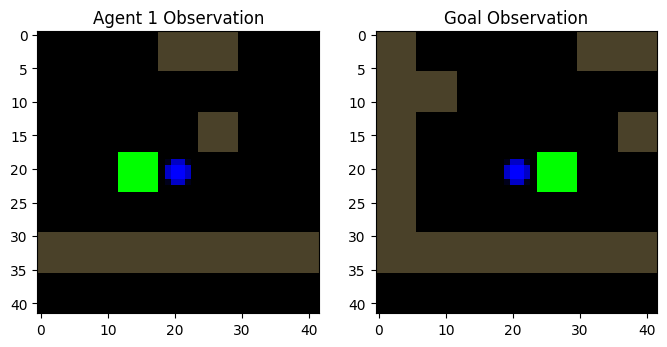

In [ ]:
#| hide
idx = 1
plot_obs_vs_goal(prev_obs, agent_idx= idx, goals= goals)

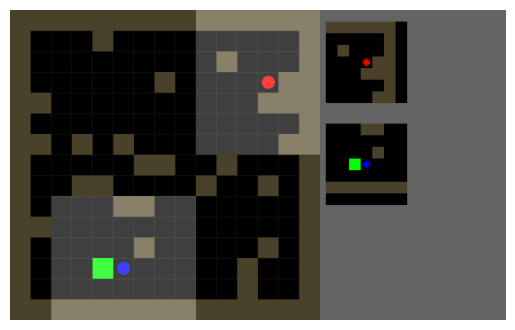

In [ ]:
#| hide
import matplotlib.pyplot as plt
new_frame = env.render(mode="rgb_array", show_more=True)
plt.imshow(new_frame)
plt.axis('off')
plt.show()

In [ ]:
#| hide
state, msg = get_agent_state(obs= prev_obs, pos= prev_pos, msgs= msgs, agent_idx= 0)
evals= actions_eval(state, msg, goal_z, device= device, agent_idx= 0)

state, msg = get_agent_state(obs= prev_obs, pos= prev_pos, msgs= msgs, agent_idx= 1)
evals1= actions_eval(state, msg, goal_z, device= device, agent_idx= 1)

evals, evals1


({'right': 966.0608520507812,
  'down': 741.7496948242188,
  'left': 606.1798706054688,
  'up': 678.7967529296875,
  'done': 972.9129028320312},
 {'right': 1005.546875,
  'down': 737.773193359375,
  'left': 635.4246826171875,
  'up': 705.86279296875,
  'done': 896.5293579101562})

In [ ]:
#| hide
optimal_action = min(evals, key=evals.get)
opt_act = min(evals1, key=evals1.get)
optimal_action, opt_act

('left', 'left')

In [ ]:
# get index of optimal actions
idx_opt_0 = list(evals.keys()).index(optimal_action)
idx_opt_1 = list(evals1.keys()).index(opt_act)
idx_opt_0, idx_opt_1

(2, 2)

In [ ]:
#| hide
obs, pos, msgs = step({f'agent_0': idx_opt_0, f'agent_1': idx_opt_1})

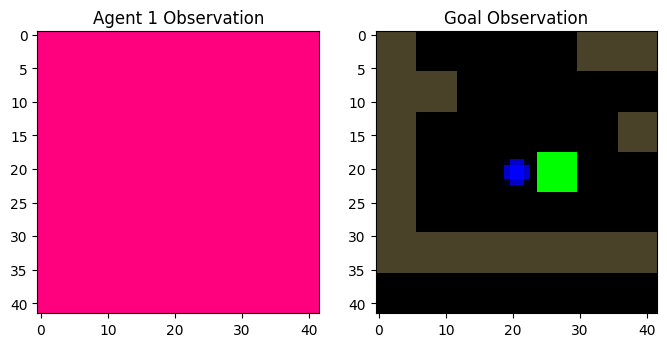

In [ ]:
#| hide
plot_obs_vs_goal(obs, agent_idx= idx, goals= goals)

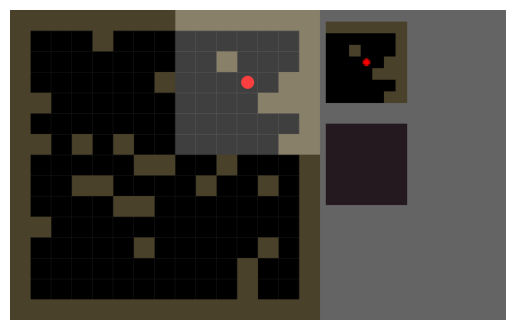

In [ ]:
#| hide
new_frame = env.render(mode="rgb_array", show_more=True)
plt.imshow(new_frame)
plt.axis('off')
plt.show()

In [ ]:
#| hide
state, msg = get_agent_state(obs= obs, pos= pos, msgs= msgs, agent_idx= 0)
evals= actions_eval(state, msg, goal_z, device= device, agent_idx= 0)

state, msg = get_agent_state(obs= obs, pos= pos, msgs= msgs, agent_idx= 1)
evals_1 = actions_eval(state, msg, goal_z, device= device, agent_idx= 1)
evals, evals_1

({'right': 971.67822265625,
  'down': 759.181396484375,
  'left': 618.9635009765625,
  'up': 716.6797485351562,
  'done': 998.4505615234375},
 {'right': 1111.5501708984375,
  'down': 807.94091796875,
  'left': 689.3941040039062,
  'up': 867.021484375,
  'done': 1093.270263671875})

In [ ]:
#| hide
optimal_action = min(evals, key=evals.get)
opt_act = min(evals_1, key=evals_1.get)
optimal_action, opt_act

('left', 'left')

In [ ]:
#| hide
# get index of optimal actions
idx_opt_0 = list(evals.keys()).index(optimal_action)
idx_opt_1 = list(evals1.keys()).index(opt_act)
idx_opt_0, idx_opt_1

(2, 2)

In [ ]:
#| hide
obs, pos, msgs = step({f'agent_0': 2, f'agent_1': 2})

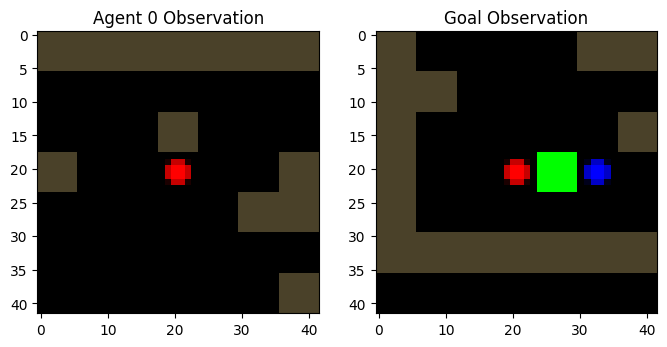

In [ ]:
#| hide
plot_obs_vs_goal(obs, agent_idx= 0, goals= goals)

In [ ]:
env.agents[1].deactivate()
env.gen_global_obs()

{'adv_indices': array([], dtype=int64),
 'agent_done': array([0., 0.]),
 'goal_pos': array([ 4, 12]),
 'sees_goal': array([0, 1]),
 'pos': array([[10,  3],
        [ 4, 12]]),
 'comm_act': array([0, 0]),
 'env_act': array([2, 2])}

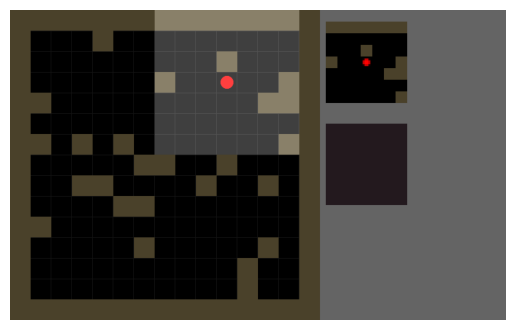

In [ ]:
#| hide
new_frame = env.render(mode="rgb_array", show_more=True)
plt.imshow(new_frame)
plt.axis('off')
plt.show()

In [ ]:
#| hide
env

<mawm.envs.marl_grid.findgoal.FindGoalMultiGrid>

In [ ]:
#| hide
state, msg = get_agent_state(obs= obs, pos= pos, msgs= msgs, agent_idx= 1)
evals= actions_eval(state, msg, goal_z, device= device, agent_idx= 1)
evals

{'right': 760.2760009765625,
 'down': 770.5057373046875,
 'left': 766.4322509765625,
 'up': 772.44384765625,
 'done': 782.3460693359375}

In [ ]:
#| hide
optimal_action = min(evals, key=evals.get)
optimal_action

'right'

In [ ]:
#| hide
obs, pos, msgs = step({f'agent_0': 0, f'agent_1': 1})

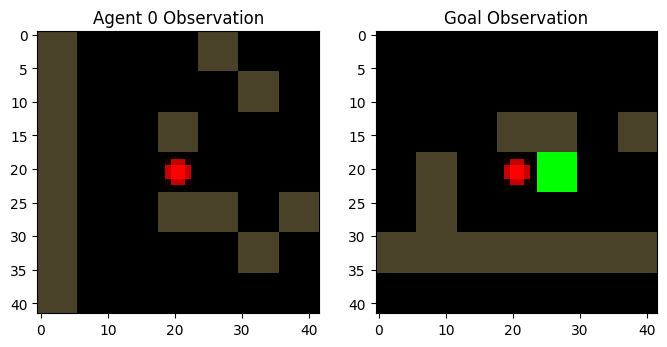

In [ ]:
#| hide
plot_obs_vs_goal(obs, agent_idx= idx, goals= goals)

In [ ]:
#| hide
state, msg = get_agent_state(obs= obs, pos= pos, msgs= msgs, agent_idx= 1)
evals= actions_eval(state, msg, goal_z, device= device, agent_idx= 1)
evals

{'right': 639.92919921875,
 'down': 631.4365234375,
 'left': 652.169921875,
 'up': 637.720947265625,
 'done': 633.674072265625}

In [ ]:
#| hide
optimal_action = min(evals, key=evals.get)
optimal_action

'down'

### Version 2

In [ ]:
#| export 
class FindGoalPlanner:

    def __init__(self, model, msg_enc, comm_module, action_dim=5, horizon=10, 
                 pop_size=1000, topk=100, opt_steps=10, 
                 agents=['agent_0', 'agent_1'], device='cpu'):
        self.model = model
        self.msg_enc = msg_enc
        self.comm_module = comm_module
        self.agents = agents
        self.device = device    
        self.action_dim = action_dim
        self.pop_size = pop_size
        self.topk = topk
        self.opt_steps = opt_steps
        self.horizon = horizon
        self.current_probs = {agent: torch.full((self.horizon, self.action_dim), 
                                                 1.0/self.action_dim, device=self.device) 
                              for agent in self.agents}
        self.loss = torch.nn.MSELoss(reduction='none')


In [ ]:
#| export
@patch    
def update_dist(self: FindGoalPlanner, costs, samples):
    for agent in self.agents:
        _, elite_indices = torch.topk(-costs[agent], self.topk)
        elites = samples[agent][elite_indices]
        
        new_probs = torch.zeros_like(self.current_probs[agent])
        for t in range(self.horizon):
            counts = torch.bincount(elites[:, t].argmax(dim=1).int(), 
                                    minlength=self.action_dim).float()
            new_probs[t] = (counts + 1e-6) / (counts.sum() + 1e-6 * self.action_dim)

        self.current_probs[agent] = new_probs



In [ ]:
#| export
@patch
@torch.no_grad()
def Plan(self: FindGoalPlanner, env, preprocessor):
        obs = env.reset()
        step = 0
        plan = {agent: [] for agent in self.agents}
        
        _, _, goals, _ = preprocessor(env, obs, pos=True, get_msg=True)
        goal_pos = obs["global"]["goal_pos"]
        position = repeat(torch.from_numpy(goal_pos).unsqueeze(0), "b d -> g b d", b=1, g=2)
        z_goals = self.model.backbone(torch.stack([goals[agent] for agent in self.agents]).to(self.device),
                                        position=position.to(self.device))
        
        z_goals = repeat(z_goals, 'b c h w -> (b s) c h w', s=self.pop_size)
        z_goals = {agent: z_goals[z_goals.size(0) // 2 * i : z_goals.size(0) // 2 * (i+1)] 
                    for i, agent in enumerate(self.agents)}
        
        while step < 100:
            prev_obs, prev_pos, _, msgs = preprocessor(env, obs, pos=True, get_msg=True)
            
            for agent in self.agents:
                self.current_probs[agent] = torch.full((self.horizon, self.action_dim), 
                                                        1.0/self.action_dim, device=self.device)
            
            total_costs = {agent: torch.zeros(self.pop_size, device=self.device) 
                                for agent in self.agents}
            for n in range(self.opt_steps):

                samples = {agent: torch.multinomial(self.current_probs[agent], self.pop_size, replacement=True).T 
                            for agent in self.agents}
                
                samples = {agent: F.one_hot(samples[agent], num_classes=self.action_dim).float().to(self.device) 
                            for agent in self.agents}
                
                start_z = self.model.backbone(
                    torch.stack([prev_obs[a] for a in self.agents]).to(self.device),
                    position=torch.stack([prev_pos[agent] for agent in self.agents]).to(self.device)
                )
                
                states = {agent: repeat(start_z[i], 'c h w -> s c h w', s=self.pop_size) 
                            for i, agent in enumerate(self.agents)}

                traj_cost = {agent: torch.zeros(self.pop_size, device=self.device) 
                         for agent in self.agents}

                Z_T = {agent: None for agent in self.agents}
                for t in range(self.horizon):
                    next_states = {}
                    for rec in self.agents:
                        sender = [a for a in self.agents if a != rec][0]
                        
                        if t == 0:
                            m = msgs[sender].to(self.device).unsqueeze(0)
                            m = repeat(m, 'b c h w -> (s b) c h w', s=self.pop_size, b=1)
                        else:
                            m = self.comm_module(states[sender].to(self.device))
                        
                        h_rec = self.msg_enc(m.to(self.device))
                        z_next = self.model.dynamics(states[rec], samples[rec][:, t], h_rec.squeeze(1))
                        next_states[rec] = z_next

                        if t == self.horizon - 1:
                            Z_T[rec] = z_next
                        
                step_loss = {agent: self.loss(next_states[agent], Z_T[agent]).mean(dim=[1, 2, 3]) for agent in self.agents}
                for agent in self.agents:
                    traj_cost[agent] += step_loss[agent]
                states = next_states

                self.update_dist(traj_cost, samples)
                
            executed_actions = {}
            for agent in self.agents:
                act = torch.argmax(self.current_probs[agent][0]).item()
                executed_actions[agent] = act
                plan[agent].append(act)

            obs, rewards, done, infos = env.step(executed_actions)

            if done.get('__all__', False): break
            step += 1
        
        return plan

In [ ]:
# #| hide
# planner = FindGoalPlanner(model, msg_enc, comm_module, horizon= 10, pop_size = 20, opt_steps= 8, topk= 6)

In [ ]:
# planner.Plan(env, preprocessor)

In [ ]:
#| hide
import nbdev
nbdev.nbdev_export() # type: ignore  # noqa: E702
